# GARNET for Jet-Images from Arpita 
## 

In [1]:
#!fusermount -u drive
#! pip install einops

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'
data_dir = '/Users/sznajder/cernbox/WorkM1/tensorflow_macos/arm64/workdir/data/hls4ml_LHCjet_150p_val/'

# Load HLS4ML dataset 

## Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

## https://github.com/pierinim/tutorials/blob/master/GGI_Jan2021/Lecture1/Notebook1_ExploreDataset.ipynb

 * 'jetImage' contains the image representation of the jets (more later)

 * 'jetImageECAL' and 'jetImageHCAL' are the ECAL- and HCAL-only equivalent images. We will not use them (but you are more than welcome to play with it)

 * 'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored

 * 'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList' 'jets' is the dataset we consider for the moment

 * 'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'


In [3]:
import numpy as np
import h5py
import os

#Data PATH
TRAIN_PATH = '/Users/sznajder/WorkM1/workdir/data/hls4ml_LHCjet_150p_train/'

# Prepare the DATA
#target = np.array([])
#jetConstituent = np.array([])
#jetImage = np.array([])

first=True
for file in os.listdir(TRAIN_PATH):
  print("Appending %s" %file)

  with h5py.File(TRAIN_PATH+file, 'r') as data:
    if first : 
        first=False
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]  # 
#        jetImage= data['jetImage'][:,:,:] 
        target = data['jets'][:,-6:-1]
    
        print("Keys in H5PY files = ",list( data.keys() ))
        print(" ")
        featurenames = data.get('jetFeatureNames')
        print("Jets Features = ",featurenames[:])
        # the b is due to the byte vs utf-8 encoding of the strings in the dataset
        # just ignore them for the moment
        print(" ")
        featurenames = data.get('particleFeatureNames')
        print("Jet Constituents Features = ",featurenames[:])
        print(" ")
        images = data.get('jetImage')
        print("Jet Images = ",images[:])        
        print("Jet Image Shape = ",images.shape)   
        print(" ")

    else:
         # Read (Pt,Etarel,Phirel)
        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,8,11]] ] , axis=0 )
         # Read (Pt,Eta,Phi)
#        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,7,10]] ] , axis=0 )
#        jetImage = np.concatenate( [ jetImage, data['jetImage']    ] , axis=0 )
        target   = np.concatenate( [ target, data['jets'][:,-6:-1] ] , axis=0 )




print("Target shape =", target.shape)
print("Jet Constituents list shape =", jetConstituent.shape)


Appending jetImage_6_150p_40000_50000.h5
Keys in H5PY files =  ['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']
 
Jets Features =  [b'j_ptfrac' b'j_pt' b'j_eta' b'j_mass' b'j_tau1_b1' b'j_tau2_b1'
 b'j_tau3_b1' b'j_tau1_b2' b'j_tau2_b2' b'j_tau3_b2' b'j_tau32_b1'
 b'j_tau32_b2' b'j_zlogz' b'j_c1_b0' b'j_c1_b1' b'j_c1_b2' b'j_c2_b1'
 b'j_c2_b2' b'j_d2_b1' b'j_d2_b2' b'j_d2_a1_b1' b'j_d2_a1_b2' b'j_m2_b1'
 b'j_m2_b2' b'j_n2_b1' b'j_n2_b2' b'j_tau1_b1_mmdt' b'j_tau2_b1_mmdt'
 b'j_tau3_b1_mmdt' b'j_tau1_b2_mmdt' b'j_tau2_b2_mmdt' b'j_tau3_b2_mmdt'
 b'j_tau32_b1_mmdt' b'j_tau32_b2_mmdt' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt'
 b'j_c1_b2_mmdt' b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt'
 b'j_d2_b2_mmdt' b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt'
 b'j_m2_b2_mmdt' b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_trim'
 b'j_mass_mmdt' b'j_mass_prun' b'j_mass_sdb2' b'j_mass_sdm1'
 b'j_multiplicity' b'j_g' b'j_q' b'j_w' b'j_z' b'

# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



In [4]:
from einops import rearrange, reduce, repeat

# Convert target format from one-hot encoding to single neuron
#target = np.argmax(target, axis=1)

# 1st dim is jet image index
# 2nd dim is image eta bin
# 3rd dim is image phi bin
njet = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat = jetConstituent.shape[2]

print('Shape of jetConstituent =',jetConstituent.shape)
print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)

# Filter out constituents with Pt<2GeV
Ptmin =2. 
constituents = np.zeros((njet, nconstit, nfeat) , dtype=np.float32) 
ij=0
max_constit=0
for j in range(njet):
    ic=0
    for c in range(nconstit):
        if ( jetConstituent[j,c,0] < Ptmin ):
            continue
        constituents[ij,ic,:] = jetConstituent[j,c,:] 
        ic+=1
    if (ic > 0):
        if ic > max_constit: max_constit=ic
        target[ij,:]=target[j,:] # assosicate the correct target a given graph 
        ij+=1


# Resizes the jets constituents and target arrays        
jetConstituent = constituents[0:ij,0:max_constit,:]
target = target[0:ij,:]


# Restric the number of constituents to a maximum of NMAX
nmax = 8
jetConstituent = jetConstituent[:,0:nmax,:]

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]

print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)


Shape of jetConstituent = (620000, 150, 3)
Number of jets = 620000
Number of constituents = 150
Number of features = 3
Number of jets = 620000
Number of constituents = 8
Number of features = 3


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing) 

In [5]:
from sklearn.model_selection import train_test_split

X = jetConstituent
Y = target
del jetConstituent , target

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

print('number of G jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==0 ))
print('number of Q jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==1 ))
print('number of W jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==2 ))
print('number of Z jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==3 ))
print('number of T jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==4 ))


print('number of G jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==0 ))
print('number of Q jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==1 ))
print('number of W jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==2 ))
print('number of Z jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==3 ))
print('number of T jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==4 ))




(415400, 8, 3) (204600, 8, 3) (415400, 5) (204600, 5)
number of G jets for training/validation: 83689
number of Q jets for training/validation: 80676
number of W jets for training/validation: 83507
number of Z jets for training/validation: 83589
number of T jets for training/validation: 83939
number of G jets for testing: 41159
number of Q jets for testing: 39535
number of W jets for testing: 41430
number of Z jets for testing: 41065
number of T jets for testing: 41411


## GARNET implementation from Arpita

In [15]:
from garnet import GarNetStack, GarNet
from tensorflow.keras import metrics
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import tensorflow.keras as keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, BatchNormalization


K = keras.backend

vmax = 8
quantize = False
x = keras.layers.Input(shape=(vmax, 3))
n = keras.layers.Input(shape=(1,), dtype='uint16')
inputs = [x, n]

x = keras.layers.BatchNormalization()(x)
v = GarNet(20, 16, 12, simplified=True, collapse='mean', input_format='xn', 
                output_activation='relu', name='gar_1', quantize_transforms=quantize)([x, n])

#v = GarNet(32, 32, 32, simplified=True, collapse='mean', input_format='xn', 
#                output_activation='relu', name='gar_1', quantize_transforms=quantize)([x, n])
#v = GarNet(32, 32, 32, simplified=True, collapse='mean', input_format='xn',
#                output_activation='relu', name='gar_1', quantize_transforms=quantize)([x, n])

v = keras.layers.Flatten()(v)
v = keras.layers.Dense(16, activation='relu')(v)
v = keras.layers.Dense(16, activation='relu')(v)
v = keras.layers.Dense(16, activation='relu')(v)

outLayer = keras.layers.Dense(5, activation='softmax')(v)

# Build the model
model = keras.Model(inputs=inputs, outputs=outLayer)

# Compile the model
optim = Adam(learning_rate=0.0002)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print the model summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 8, 3)]       0                                            
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 8, 3)         12          input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
gar_1 (GarNet)                  (None, 16)           3984        batch_normalization_5[0][0]      
                                                                 input_12[0][0]             

# Define the Model and Compile 


## Run training
Here, we run the training.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
model_checkpoint = ModelCheckpoint('Garnet_arpita.h5', monitor='val_categorical_accuracy', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

# Train classifier
V_train_val =  np.ones((X_train_val.shape[0],1))*vmax
history = model.fit( [ X_train_val, V_train_val ] , Y_train_val, 
                    epochs=50, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[lr_scheduler , early_stopping, model_checkpoint], 
                    validation_split=0.33 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 
                    

Epoch 1/50
544/544 [==============================] - 3s 6ms/step - loss: 1.4420 - categorical_accuracy: 0.3882 - val_loss: 1.3392 - val_categorical_accuracy: 0.4354
Epoch 2/50
544/544 [==============================] - 3s 5ms/step - loss: 1.1895 - categorical_accuracy: 0.5186 - val_loss: 1.1458 - val_categorical_accuracy: 0.5466
Epoch 3/50
544/544 [==============================] - 3s 5ms/step - loss: 1.1217 - categorical_accuracy: 0.5528 - val_loss: 1.1011 - val_categorical_accuracy: 0.5681
Epoch 4/50
544/544 [==============================] - 3s 5ms/step - loss: 1.0885 - categorical_accuracy: 0.5731 - val_loss: 1.0733 - val_categorical_accuracy: 0.5849
Epoch 5/50
544/544 [==============================] - 3s 5ms/step - loss: 1.0667 - categorical_accuracy: 0.5858 - val_loss: 1.0538 - val_categorical_accuracy: 0.5939
Epoch 6/50
544/544 [==============================] - 3s 6ms/step - loss: 1.0514 - categorical_accuracy: 0.5937 - val_loss: 1.0411 - val_categorical_accuracy: 0.5996
Epoc

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

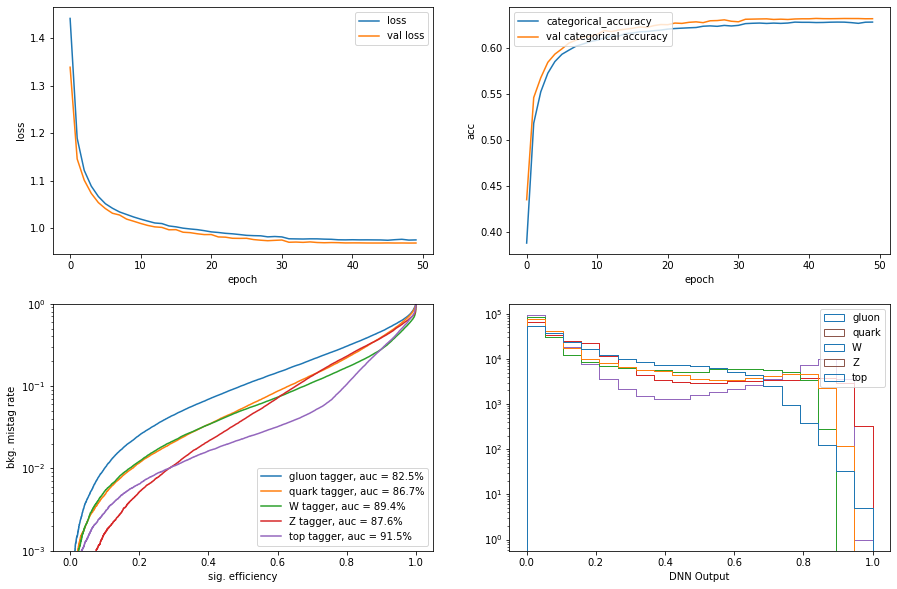

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}

ax = plt.subplot(2, 2, 3)

V_test =  np.ones((X_test.shape[0],1))*vmax
Y_predict = model.predict([X_test, V_test])

for i, label in enumerate(labels):
    fpr[label], tpr[label], _ = roc_curve(Y_test[:,i], Y_predict[:,i])
    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
    
ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(loc='lower left')
ax.legend(prop={'size': 10})

# Display plots
plt.show()

    

In [ ]:
# Save FPR for a given TPR value ( 30% , 50% & 80%) 
model_name = 'Garnet'
with open('performance_'+model_name+'_nconst_'+str(nmax)+'_nbits_'+str(nbits)+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( model_name+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")